## Using an external library to provide the mesh

Now, we will load a mesh from a URL by using a simple library. This is just to avoid filling up the notebook
with lots of junk - the library is very simple, you can find it at: https://raw.githubusercontent.com/chrisrichardson/meshdata/master/micromesh/micromesh.py

So far, it just consists of two functions, `get()` which pulls a mesh from a URL, and `plot()` which plots the mesh and data values using matplotlib. First we use `wget` to pull the python file, then we import it.

In [12]:
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt

# Get simple mesh IO/plotting library
!wget -q -nc https://raw.githubusercontent.com/chrisrichardson/meshdata/master/micromesh/micromesh.py
import sys
sys.path.insert(0,'.')
import micromesh

Read the mesh data from the URL. It returns a Python "dict" object with keys "geometry", "topology" and "data".

In [13]:
mesh = micromesh.get('https://raw.githubusercontent.com/chrisrichardson/meshdata/master/data/rectangle_mesh.xdmf')

[5, 11, 17, 23]


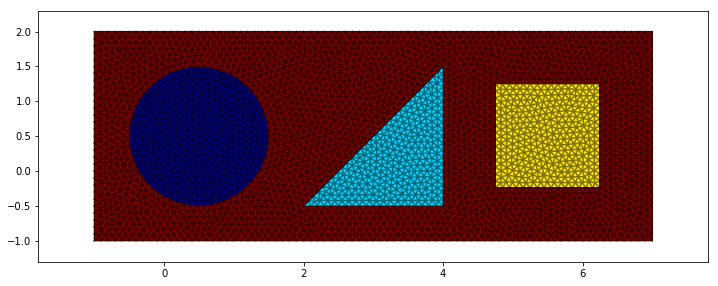

In [17]:
# Plot the 'marker' function of the mesh
plt.figure(figsize=(12, 6))
marker = mesh['data'][0]['value']
micromesh.plot(mesh, marker, cmap='jet')
# Get the set of values in the marker function
print(sorted(set(marker)))

In [18]:
def Kmat(D, p, geometry):
    ''' Calculate the local element matrix K from the D matrix and the points '''
    # D contains the conductivity tensor
    # p contains the indices of the three points making up the triangle
    assert(len(p) == 3)
    x0, y0 = geometry[p[0]]
    x1, y1 = geometry[p[1]]
    x2, y2 = geometry[p[2]]
    
    # Element area Ae
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))
    
    # 'B' Matrix - representing the 'gradient' operator
    B = array([[y1 - y2, y2 - y0, y0 - y1],
               [x2 - x1, x0 - x2, x1 - x0]])/(2*Ae)

    K = Ae*matmul(B.transpose(), matmul(D, B))
    return K

In [19]:
def assemble_matrix(mesh, Dmat):
    ''' Assemble the global matrix, using D values defined by the marker function. Dmat is a dict
        which maps from a marker value to a matrix. A default value should be provided in Dmat[0].'''
    geom, topo = mesh['geometry'], mesh['topology']
    marker = mesh['data'][0]['value']
    np = len(geom)
    Kglobal = zeros((np, np))
    
    for n, tri in enumerate(topo):
        mk = marker[n]
        # Try to find the D matrix for the marker in this triangle, or default to Dmat[0]
        if mk in Dmat.keys():
            D = Dmat[mk]
        else:
            D = Dmat[0]
        K = Kmat(D, tri, geom)
        for i, idx in enumerate(tri):
            for j, jdx in enumerate(tri):
                Kglobal[idx, jdx] += K[i, j]
    return Kglobal

In [20]:
# Define D conductivity tensor for the different regions.
Dmat = { 0:array([[1.0, 0.0],   [0.0, 1.0]]), 
         5:array([[1000.0, 0.0], [0.0, 1000.0]]), 
         11:array([[1000.0, 0.0], [0.0, 1000.0]]), 
         17:array([[100.0, 0.0],  [0.0, 1.0]])}

In [21]:
Kglobal = assemble_matrix(mesh, Dmat)

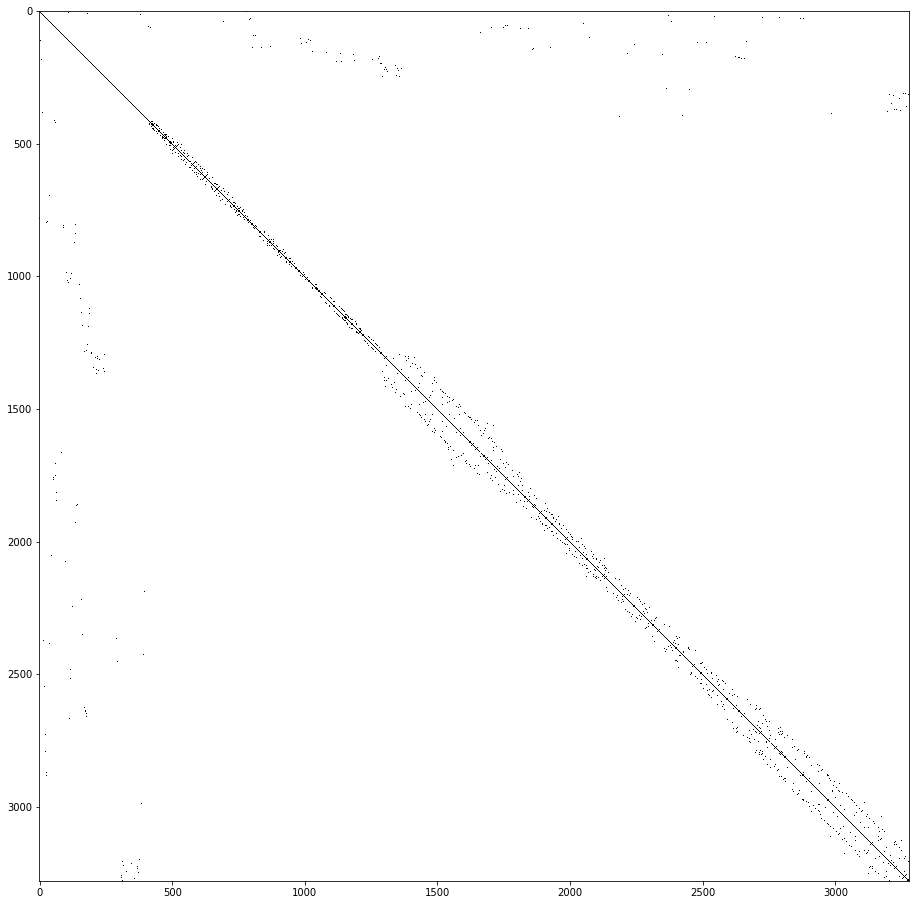

In [22]:
# Show the non-zero structure of the matrix (top left corner) - note that it is symmetric,
# and contains some entries far off the diagonal.
plt.figure(figsize=(16, 16))
nz = plt.imshow((Kglobal!= 0), interpolation='nearest', cmap='Greys')

In [27]:
# RHS assembly
def fvec(s, p, geometry):
    assert(len(p) == 3)
    x0, y0 = geometry[p[0]]
    x1, y1 = geometry[p[1]]
    x2, y2 = geometry[p[2]]

    # Element area Ae
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))
    return s*Ae/3.0*ones(3)

def assemble_vector(mesh, sval):
    geom, topo = mesh['geometry'], mesh['topology']
    marker = mesh['data'][0]['value']
    fg = zeros(len(geom))
    for n,tri in enumerate(topo):
        mk = marker[n]
        # Look for marker in sval, else just use sval[0]
        if mk in sval.keys():
            s = sval[mk]
        else:
            s = sval[0]
        f = fvec(s, tri, geom)
        for i, idx in enumerate(tri):
            fg[idx] += f[i]
    return fg

# Set source/sink terms for the different regions
s = {0:0.0, 5:0.0, 11:10.0, 17:10.0}
fglobal = assemble_vector(mesh, s)

In [28]:
# Set the Dirichlet Boundary Conditions by clearing a row,
# setting the diagonal to 1, and putting the value on the RHS.
def set_bc(K, f, row, val):
    # Set BC
    K[row] = 0.0
    K[row, row] = 1.0
    f[row] = val

# Find points for BCs geometrically
for i,x in enumerate(mesh['geometry']):
    if x[0] == -1.0:
        set_bc(Kglobal, fglobal, i, 1.0)
    elif x[0] == 7.0:
        set_bc(Kglobal, fglobal, i, -1.0)


9.837773466730676 -1.000000000000001


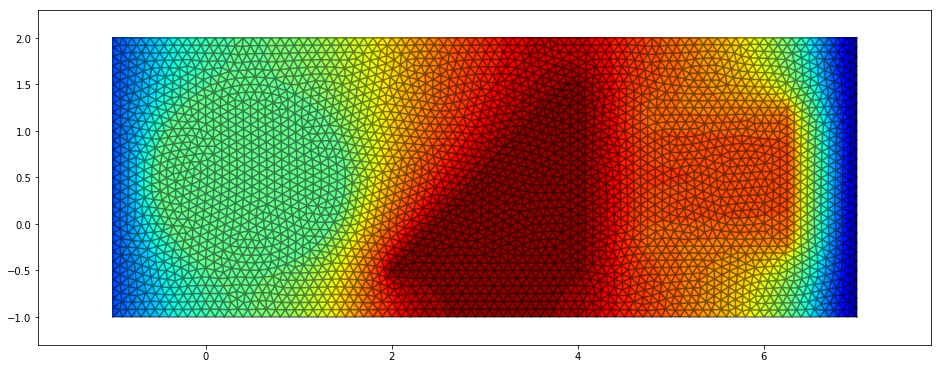

In [29]:
u = linalg.solve(Kglobal, fglobal)
print(u.max(), u.min())
plt.figure(figsize=(16,16))
micromesh.plot(mesh, u, cmap='jet')